In [6]:
using OrdinaryDiffEq, ParameterizedFunctions
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260


# Viral kinetic model

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*

The standard kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$
the goal now is to fit this model to data.

## Data set

10 mice with 13 data points each

In [42]:
tdata = [range(0, 12 , step=1.0);]
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')'

13×10 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 4.18551  3.99136  3.49136  3.29788     3.49136  4.00515  3.49136  4.50515
 5.67816  5.47712  5.44716  5.77233     5.7954   6.03148  6.18551  6.17215
 6.00515  5.84488  5.81012  6.24612     5.74951  5.83815  5.78784  6.03148
 5.9364   5.82436  5.83815  5.49136     6.03148  6.26036  5.59921  5.49136
 5.97712  5.81012  5.78016  5.9624   …  5.82436  6.1294   5.97712  5.34242
 5.44716  5.0874   5.2954   5.14412     5.2954   5.18551  5.34488  5.81012
 5.19848  4.49136  5.01851  5.51851     5.17215  4.83815  5.47712  5.01188
 4.00515  0.0      2.94716  3.23882     3.26036  0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0    

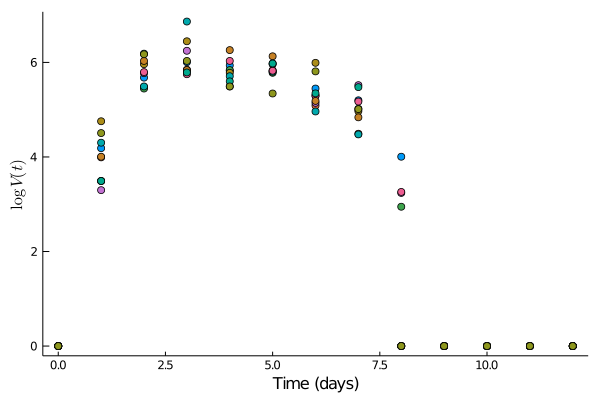

In [43]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[:, i], seriestype=:scatter) for i in 1:size(data, 2)]
plt

### Average of data

In [44]:
vdata_avg = mean(data, dims=2)
vdata_std = std(data, dims=2);

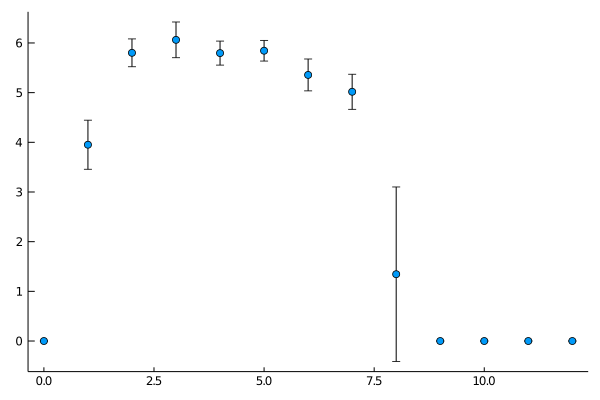

In [45]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off)

### Model

In [46]:
# function viral_target!(du, u, pars, t)
#     T, I₁, I₂, V = u
#     β, k, δ, K, p, c = pars
#     du[1] = dT = -β*T*V
#     du[2] = dI₁ = β*T*V - k*I₁
#     du[3] = dI₂ = k*I₁ - δ*I₂/(K + I₂)
#     du[4] = dV = p*I₂ - c*V
# end
f = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c

(::var"##582"{var"###ParameterizedDiffEqFunction#679",var"###ParameterizedTGradFunction#680",var"###ParameterizedJacobianFunction#681",Nothing,Nothing,ODESystem}) (generic function with 1 method)

In [68]:
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, 9.0)
pars = (β = 9.9e-5,
        k = 4.0,
        δ = 1.65e+6,
        K = 1.134e+5,
        p = 1.7,
        c = 12.48)
prob = ODEProblem(f, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 9.0)
u0: [1.0e7, 75.0, 0.0, 1.0]

In [69]:
sol = solve(prob, Tsit5());

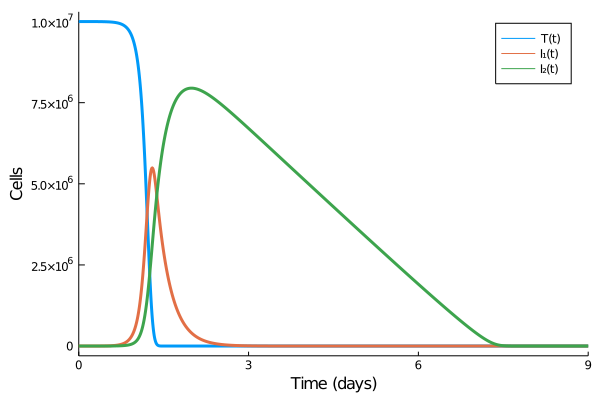

In [49]:
plot(sol, vars=(1:3), lw=3, xlabel="Time (days)", ylabel="Cells", grid=:off)

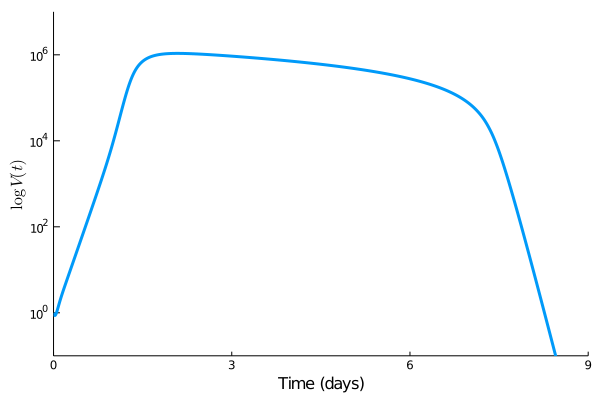

In [51]:
plot(sol, vars=(4), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (1e-1, 1e+7), :log10))

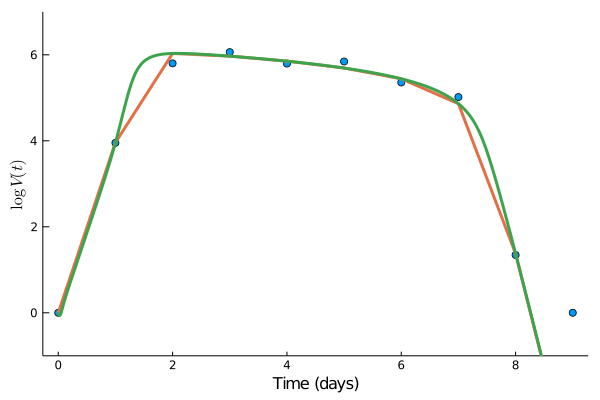

In [76]:
plot(tdata, vdata_avg, seriestype=:scatter)
tdata = [range(0., 9., step=1.);]
plot!(tdata, log10.(sol(tdata)[4, :]), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
ttdata = [range(0., 9., step=1e-2);]
plot!(ttdata, log10.(sol(ttdata)[4, :]), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))


In [64]:
sum((log10.(sol(tdata)[4, :]) - vdata_avg[1:10]).^2)

15.64271422026487